*Midterm - Liam Wright, 7/14/2025*

**1. Risk Statistics and Decomposition**

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

#Given
DATAFILE = '/home/lwright02/Quant-Summer-2025/data/midterm_data.xlsx'
SHEET_INFO = 'info'
info = pd.read_excel(DATAFILE,sheet_name=SHEET_INFO)
info.set_index('ticker',inplace=True)
rets = pd.read_excel(DATAFILE,sheet_name='excess returns')
rets.set_index('date',inplace=True)
rets.columns = [s.split(' ')[0] for s in rets.columns]
rets = rets[info.index]

#Helper functions for each def
def annualize(weekly_vals):
    return weekly_vals.mean() * 52
def annual_vol(weekly_vals):
    return weekly_vals.std() * np.sqrt(52)
def sharpe(weekly_vals):
    return annualize(weekly_vals) / annual_vol(weekly_vals)
def max_drawdown(series):
    cum_returns = (1 + series).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    return drawdown.min()

#Graph Display
stats = pd.DataFrame({
    'mean_ann': annualize(rets),
    'vol_ann': annual_vol(rets),
    'sharpe': sharpe(rets),
    'skew': rets.skew(),
    'kurt': rets.kurtosis(),
    'max_drawdown': rets.apply(max_drawdown)
})
stats

,mean_ann,vol_ann,sharpe,skew,kurt,max_drawdown
SPY,0.118939,0.171315,0.694271,-0.627808,6.363700,-0.325741
AAPL,0.227994,0.276003,0.826057,-0.214185,1.852149,-0.348104
NVDA,0.653633,0.461871,1.415184,0.336949,1.391086,-0.657787
MSFT,0.253320,0.239516,1.057631,0.066817,2.372360,-0.350826
GOOGL,0.220044,0.279465,0.787376,0.572854,3.673239,-0.415141
AMZN,0.300886,0.305453,0.985051,0.061550,1.754491,-0.545830
META,0.274415,0.352006,0.779574,0.062078,3.990455,-0.758756
TSLA,0.462420,0.586525,0.788407,0.535479,1.585674,-0.721138
AVGO,0.382419,0.375069,1.019597,0.639696,3.515656,-0.409481
BRK-B,0.130218,0.189958,0.685508,-0.199913,2.608872,-0.266894


**1.2**
- As a standalone investment, NVDA look to be the most attractive, as it has the highest Sharpe Ratio, with the largest mean annual return. The least attractive standalone invesment looks like the BRK-B and the SPY which have the lowest Sharpe Ratios, and the lowest mean annual returns.

In [100]:
from sklearn.linear_model import LinearRegression
results = {}
spy = rets['SPY'].values.reshape(-1, 1)

# Copilot ->Propmt: "loop to estimate alpha/beta/info ratio/R² from a regression of all tickers against SPY in my returns DataFrame"
for ticker in rets.columns.drop('SPY'):
    asset = rets[ticker]
    lr = LinearRegression().fit(spy, asset)
    alpha = asset.mean() - lr.coef_[0] * spy.mean()
    beta = lr.coef_[0]
    predicted = lr.predict(spy)
    residuals = asset - predicted
    info_ratio = residuals.mean() / residuals.std() * np.sqrt(52)
    r2 = lr.score(spy, asset)
    
    results[ticker] = {
        'alpha_ann': alpha * 52,
        'beta': beta,
        'info_ratio': info_ratio,
        'r_squared': r2
    }

regression_df = pd.DataFrame(results).T
regression_df


,alpha_ann,beta,info_ratio,r_squared
AAPL,0.096511,1.105465,-2.759745e-16,0.470818
NVDA,0.449431,1.716860,-2.963732e-17,0.405526
MSFT,0.131683,1.022681,1.938708e-16,0.535057
GOOGL,0.093870,1.060832,3.728469e-17,0.422891
AMZN,0.174753,1.060484,1.719277e-16,0.353762
META,0.137196,1.153691,-1.811687e-17,0.315260
TSLA,0.258016,1.718565,1.768477e-16,0.251971
AVGO,0.221165,1.355773,-1.433513e-16,0.383480
BRK-B,0.033790,0.810733,-7.126300e-17,0.534602
LLY,0.195315,0.616715,-8.028741e-17,0.139036


**1.4** 
- Relative to holding SPY, the NVDA is likely the most attractive investment as it has a very strong alpha, with a decent R^2 value. The beta is quite high though so it may be a little risky.

In [68]:
X = rets[['SPY', 'NVDA']]
y = rets['AAPL']

lr = LinearRegression().fit(X, y)
weights = lr.coef_
intercept = lr.intercept_

print(f"SPY: {-weights[0]:.2f}\nNVDA: {-weights[1]:.2f}")

SPY: -1.02
NVDA: -0.05


For every $100 in AAPL, we should short 1.02 in SPY and 0.05 in NVDA.

**1.6**
- In replicating AAPL using SPY, and NVDA, the R^2 statistic best indicates if our replication tracks the target well. The R^2 literally track how well the AAPL returns are explained by SPY and NVDA.

**1.7** 
- In the ProShares case we did indeed find the replication attempt successful. We achieved an 81.2% correlation in the HFRI Index. The replication strategy using Merrill Lynch factors closely tracked the hedge-fund index returns. Some drawback to using our replication over the direct product involve the replication’s tracking error which may be low but is still there, meaning some risk and return differences remain. Therefore it is not a perfect substitute. The replication also does not fully capture all of the complex strategies of the hedge-fund.

**2. Portfolio Allocation**

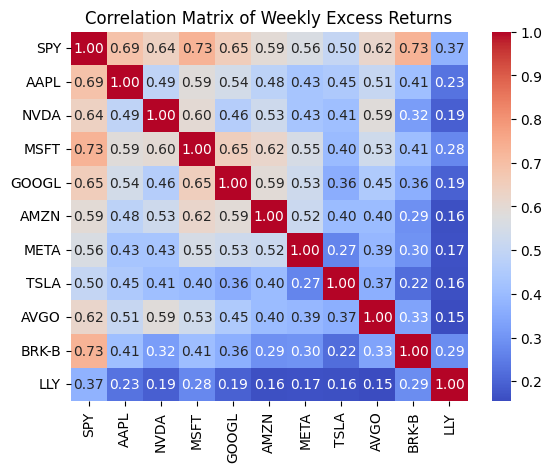

In [69]:
correlation_matrix = rets.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Weekly Excess Returns")
plt.show()

I anticipate that LLY will get extra weight in the portfolio, beyond what it would merit for its mean return because it has the lowest correlation with pretty much all of the other assets, thus it will provide diversification benefits to a portfolio. This would then lower risk.

In [70]:
mu = rets.mean() * 52
cov = rets.cov() * 52

# Invert covariance matrix
cov_inv = pd.DataFrame(
    data=np.linalg.inv(cov.values), 
    index=cov.columns, 
    columns=cov.columns
)

raw_weights = cov_inv @ mu
normalizer = (cov_inv @ mu).sum()
tangency_weights = raw_weights / normalizer

tangency_weights = tangency_weights.rename("Tangency Weights")
print(tangency_weights)

SPY     -7.893588
AAPL     0.477018
NVDA     1.067801
MSFT     0.859136
GOOGL    0.298598
AMZN     0.536354
META     0.385017
TSLA     0.337308
AVGO     0.645620
BRK-B    3.084359
LLY      1.202377
Name: Tangency Weights, dtype: float64


In [98]:
weights = tangency_weights
mu_aligned = mu.loc[weights.index]
cov_aligned = cov.loc[weights.index, weights.index]

port_mean = weights.dot(mu_aligned)
port_var = weights.dot(cov_aligned.dot(weights))
port_vol = port_var ** 0.5
port_sharpe = port_mean / port_vol

print(f"Annualized Mean: {port_mean:.4f}")
print(f"Annualized Volatility: {port_vol:.4f}")
print(f"Annualized Sharpe Ratio: {port_sharpe:.4f}")

Annualized Mean: 1.5458
Annualized Volatility: 0.7235
Annualized Sharpe Ratio: 2.1364


**2.4**
- The largest positive weight typically has the highest Sharpe ratio, as the optimizer favors assets with higher expected returns relative to their risk. In our case, the BRK-B has the biggest positive weight and SPY has the most negative weight. Neither of them have the biggest sharpe ratios. The optimizer does't assign weights solely based on each asset’s standalone Sharpe ratio, but rather maximizes the portfolio’s overall Sharpe ratio by considering other variables such as expected returns, and correlations b/w assets.

In [88]:
rets_no_spy = rets.drop(columns='SPY')
mu2 = rets_no_spy.mean() * 52
cov2 = rets_no_spy.cov() * 52

# Invert covariance
cov2_inv = pd.DataFrame(
    np.linalg.inv(cov2.values), 
    index=cov2.columns, 
    columns=cov2.columns
)

raw_weights = cov2_inv.dot(mu2)
tangency_weights_pandas = raw_weights / raw_weights.sum()

tangency_no_spy = tangency_weights_pandas.rename("Tangency Weights w/o SPY")
print(tangency_no_spy)

AAPL    -0.078166
NVDA     0.370675
MSFT     0.014582
GOOGL   -0.071598
AMZN     0.145160
META     0.028621
TSLA     0.038724
AVGO     0.104653
BRK-B    0.047814
LLY      0.399535
Name: Tangency Weights w/o SPY, dtype: float64


**2.6**
- performance of the tangency portfolio. **True**
- weights of the tangency portfolio. **True**
- correlation structure of the assets. **False**

**2.7**
1. The optimized portfolio is unrealistic in practice because tt often produces extreme long and short positions that are impossible. For example, in lecture we talked about going long 200%+ in one asset and 200%+ short in another, which will never happen in real life.

2. Harvard uses robust optimization to make theirs more practical. Harvard incorporates uncertainty which results in stabler and more realistic portfolios that are less sensitive to estimation error.

3. Harvard optimized in levels because it gives more control and a better estimation as asset class level parameters are stabler and easier to estimate than individual security parameters. It also reduce complexity.

**3. Expected Returns**

In [79]:
nvda = rets['NVDA'].dropna()
spy = rets['SPY'].dropna()
lr = LinearRegression().fit(spy.values.reshape(-1, 1), nvda)

beta = lr.coef_[0]
alpha = lr.intercept_
alpha_ann = alpha * 52
r2 = lr.score(spy.values.reshape(-1, 1), nvda)

print(f"R²: {r2:.4f}")
print(f"Beta: {beta:.4f}")
print(f"Annualized Alpha: {alpha_ann:.4f}")

R²: 0.4055
Beta: 1.7169
Annualized Alpha: 0.4494


**3.2**
- My regression only has an R^2 of 0.4055, and it also has a positive alpha. The weak R^2 shows that it doesn't price very accurately.

**3.3**

In [80]:
nvda = rets['NVDA'].dropna()
nvda_mean_ann = nvda.mean() * 52
print(f"Avg Excess Return: {nvda_mean_ann:.4f}")

spy = rets['SPY'].loc[nvda.index]  # Align dates
spy_mean_ann = spy.mean() * 52
expected_return_capm = beta * spy_mean_ann
print(f"Excess Return explained by Factor Risk: {expected_return_capm:.4f}")

Avg Excess Return: 0.6536
Excess Return explained by Factor Risk: 0.2042


**3.4**

In [81]:
# Lag SPY
spy_lagged = rets['SPY'].shift(1).dropna()
nvda = rets['NVDA'].loc[spy_lagged.index]  # Align NVDA with lagged SPY

forecast_lr = LinearRegression().fit(spy_lagged.values.reshape(-1, 1), nvda)
forecast_beta = forecast_lr.coef_[0]
forecast_alpha = forecast_lr.intercept_
forecast_r2 = forecast_lr.score(spy_lagged.values.reshape(-1, 1), nvda)

print(f"Alpha (weekly): {forecast_alpha:.4f}")
print(f"Beta: {forecast_beta:.4f}")
print(f"R-squared: {forecast_r2:.4f}")

Alpha (weekly): 0.0131
Beta: -0.2279
R-squared: 0.0071


**3.5**
- From our data we have a very low R^2, thus confirming that SPY’s lagged return isn;t a meaningful signal for NVDA’s weekly movement. Our R^2 tells us that SPY explains less than 1% of NVDA’s weekly return variance. Our slight alpha tells us that NVDA tends to rise even when SPY is flat but the model is such a weak predictor that it doesn;t really matter. We can conclude that NVDA’s movements are driven by factors outside of simple market lag

**3.6**

In [82]:
forecast_alpha = 0.0131
forecast_beta = -0.2279

# Most recent SPY excess return
spy_latest = rets['SPY'].iloc[-1]

# Forecasted NVDA weekly return for early July 2025
expected_nvda_weekly = forecast_alpha + forecast_beta * spy_latest

expected_nvda_annual = expected_nvda_weekly * 52

print(f"7/2025 NVDA Forecasted return: {expected_nvda_annual:.4f}")

7/2025 NVDA Forecasted return: 0.2806


**3.7**
- Creating style factors which go long and short the targeted style serves to reduce biases and confounders. It also removes market exposure and enhances validity. Essentially, without this this, one can't tell if returns came from market moves or the factor itself.